In [7]:
from pathlib import Path
import sys

notebook_dir = Path.cwd()
others_path = notebook_dir.parent

others_path = others_path.resolve()
if str(others_path) not in sys.path:
    sys.path.append(str(others_path))

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


import eos
import kernels
import gaussianprocess
import prepare_ceft as pc
import prepare_pqcd as pp
import sampling as sam
import anal_helpers as anal
from constants import ns, crust_end, get_phi
from pqcd.pQCD import pQCD

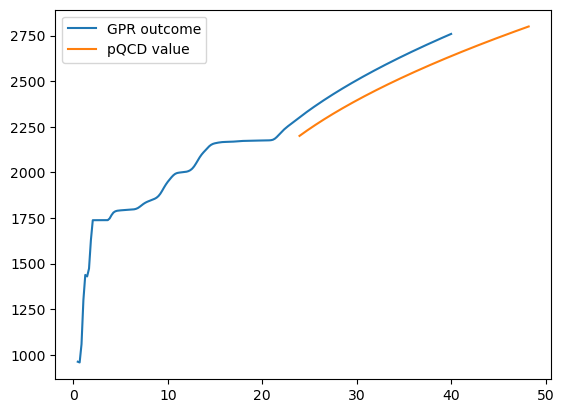

pQCD connection consistent: True


In [21]:
boo = False
while not boo:
    n_ceft, cs2_ceft_avg, phi_ceft_sigma, e_ini, p_ini, mu_ini, n_crust, e_crust, p_crust, cs2_crust = pc.make_conditioning_eos()

    cs2_hat, X_hat, nu_hat, l_hat, alpha_hat = sam.get_hype_samples()

    kernel = kernels.Kernel('SE', sigma=nu_hat**0.5, l=l_hat)

    n_ceft_end_hat = 2

    idx = np.searchsorted(n_ceft, n_ceft_end_hat)
    idx_or_before = np.argmin([np.abs(n_ceft[idx-1]-n_ceft_end_hat), np.abs(n_ceft[idx]-n_ceft_end_hat)])
    if idx_or_before == 1:
        idx = idx+1

    n_ceft = n_ceft[:idx]
    cs2_ceft_avg = cs2_ceft_avg[:idx]
    phi_ceft_sigma = phi_ceft_sigma[:idx]

    n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, 2.2, 2.8, size=200) # nsat, unitless
    mu_pqcd = np.linspace(2.2*1000,2.8*1000,200)

    x_train =  np.concatenate((n_crust[-10:-1],n_ceft, n_pqcd)) #nsat
    cs2_train =  np.concatenate((cs2_crust[-10:-1],cs2_ceft_avg, cs2_pqcd)) # crust excluding last element because it is already in ceft

    phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
    phi_crust_sigma = np.zeros_like(cs2_crust[-10:-1])

    phi_sigma_train = np.concatenate((phi_crust_sigma, phi_ceft_sigma, phi_pqcd_sigma))
    phi_train = get_phi(cs2_train)
    train_noise = phi_sigma_train**2

    x_test = np.linspace(n_ceft[0], 40, 200) # number density in nsat, starting val is ending val of n crust, ending val is default 10 nsat

    gp = gaussianprocess.GP(kernel, get_phi(cs2_hat))
    gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

    phi_test = gp.posterior(sampling=True)

    phi_test = phi_test.flatten()
    phi_test[0] = get_phi(cs2_crust[-1]) # minor difference in gpr result and actual crust ending so replacing gpr val

    EOS = eos.EosProperties(x_test, phi_test, epsi_0=e_ini, p_0=p_ini, mu_0=mu_ini)
    eos_result = EOS.get_all()

    n_term = 15

    p_interp = interp1d(x_test, eos_result["pressure"], bounds_error=False, fill_value="extrapolate")
    e_interp = interp1d(x_test, eos_result["epsilon"], bounds_error=False, fill_value="extrapolate")

    p_term = p_interp(n_term)
    e_term = e_interp(n_term)

    boo = pp.check_pqcd_connection(X_hat, e_term, p_term, n_term)


plt.plot(x_test, eos_result["mu"], label = "GPR outcome")
plt.plot(n_pqcd, mu_pqcd, label = "pQCD value")
plt.legend()
plt.show()


print(f"pQCD connection consistent: {boo}")

# Conclusion

The pQCD is checked at $\mu=2.6$ GeV for the high eos point.

The low eos point is set by n_term.

As n_term increases, there's fewer possibilites of connecting consistently.

As such, when increasing n_term, the GPR predicted values for $\mu$ get closer to the pQCD input values. 

But this does not mean that the predicted and input $\mu$ have to match up exactly. 

I assume if n_pqcd was the same as n_term, then the value for predicted and input $\mu$ would be equal at that point at least. But matching at such high density would take too long.

So, this way of conditioning on pQCD and matching it does not really guarantee a unified description of the EOS. 

# also using this for the hyperparams

r = l means k_SE = exp(-1/2)

root finding to find the scale factor for the matern kernels, ended up going with visual inspection instead

In [160]:
import numpy as np
from scipy.optimize import root_scalar

def matern32_match_se():
    target = np.exp(-0.5)
    def func(x):
        return (1 + np.sqrt(3)*x) * np.exp(-np.sqrt(3)*x) - target
    
    sol = root_scalar(func, bracket=[0.01, 2], method='brentq')
    x = sol.root
    scaling_factor = 1 / x
    return scaling_factor

s = matern32_match_se()
print(f"Scaling factor for Matérn 3/2: {s:.4f}")

Scaling factor for Matérn 3/2: 1.2757


In [ ]:
import numpy as np
from scipy.optimize import root_scalar

def matern52_match_se():
    target = np.exp(-0.5)
    def func(x):
        return (1 + np.sqrt(5)*x + 5*x**2/3) * np.exp(-np.sqrt(5)*x) - target

    sol = root_scalar(func, bracket=[0.01, 2], method='brentq')
    x = sol.root
    scaling_factor = 1 / x
    return scaling_factor

s = matern52_match_se()
print(f"Scaling factor for Matérn 5/2: {s:.4f}")

Scaling factor for Matérn 5/2: 1.1608


# 3d n, mu, cs2 plots